In [1]:
%matplotlib inline 
import numpy as np 
import numpy.ma as ma #Pour les masked array
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations

import matplotlib.ticker as ticker  #perso
from matplotlib.backends.backend_pdf import PdfPages #perso

In [2]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = './'    #le fichier est dans le répertoire courant
dir_out = './'  # the directory where the output of this notebook will be stored

In [3]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'ez'

In [4]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

In [5]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

print(filt_dict['GALEX_FUV'][0])

1526.0000000000002


In [6]:
# Upload the main catalogue
#cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

### je n'ai pas un fichier du même nom, je modifie en conséquence

cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

In [7]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = [i in filt_use for i in filt_name]

### Je crois que cela ne change rien si je l'active ou non

In [8]:
# Have a quick look inside the table
cat0[[0,-1]]
#at0[0]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [9]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 964506 sources
Now restricted to 746976 sources by using FLAG_COMBINED


In [10]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [11]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

In [12]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col] 
                else:
                    tab[c+flx_col] += tab[scale_col]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [13]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)

In [14]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [15]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

In [16]:
cat = cat1.copy()

# j'ai renommé pour simplifier
cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','alpha')
cat.rename_column('DELTA_J2000','delta')
cat.rename_column('ez_z_phot','z')

cat[[0,-1]]

ID,alpha,delta,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,photoz,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,

# Debut de la partie perso

In [17]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Créer les coordonnées SkyCoord pour cat
cat_coords = SkyCoord(ra=cat['alpha'], dec=cat['delta'], unit='deg')

# Créer les coordonnées SkyCoord pour galaxies_G237
galaxies_G237 = [np.loadtxt('galax_G237.txt')[:, -3], np.loadtxt('galax_G237.txt')[:, -2]]
galaxies_coords = SkyCoord(ra=galaxies_G237[0], dec=galaxies_G237[1], unit='deg')

# Effectuer le matching en utilisant une boucle
idx = []
d2d = []
threshold = 0.5 * u.arcsec

for galaxy_coord in galaxies_coords:
    sep_constraint = cat_coords.separation(galaxy_coord) < threshold
    if np.any(sep_constraint):
        idx.append(np.where(sep_constraint)[0][0])
        d2d.append(cat_coords[idx[-1]].separation(galaxy_coord))

# Sélectionner les lignes correspondantes dans cat
matched_cat = cat[idx]

# Afficher les lignes correspondantes
print(matched_cat, '\n', len(matched_cat['alpha']))

# Incroyable, ça marche mais je passe de 24 galaxies avec le système d'ID à
# 26 avec le matching des coordonées

  ID         alpha        ...      ez_Av_p840          ez_Av_p975    
              deg         ...         mag                 mag        
------ ------------------ ... ------------------- -------------------
925194 150.38351009367906 ... 0.46611031677765097  0.5069361734001858
930767 150.37855482542793 ...  1.8265592046790389  1.9547355876486703
174844  150.3818123762897 ...  1.8153592072598848   1.861582355598522
200398 150.49413145972386 ...  1.1458355948324739  1.2706770642606384
358037 150.54598225136124 ...  2.8211931908143715  2.9104332246655584
566809 150.37444037169632 ...  0.7200496445206573   0.762335885316791
713057  150.5513234323465 ...   2.306810629624648  2.5000084873501622
822664 150.53190451373573 ...  0.5354503875224091  0.6439756288791413
853095  150.5032714911398 ...  1.6571193457989328  1.9606155902769642
180584  150.5243378630622 ...  0.7162010950430822  0.8408129969929293
   ...                ... ...                 ...                 ...
595398 150.393062322

   UVISTA_Y_FLUX   
        uJy        
-------------------
0.16430571245974185
0.15451267991639636
0.24321923151572147
0.22351043493500686
 0.1405086427623365
0.18004386061002164
0.20310263356078728
0.18147781692282125
0.18666407775041224
 0.2113512506138994
                ...
                 --
0.16205737010889873
0.23546719663441135
                 --
0.19541141680290805
0.19646585650155965
0.16814743944729182
0.18782054543220855
0.04432470968574946
0.15490564952645364
Length = 26 rows


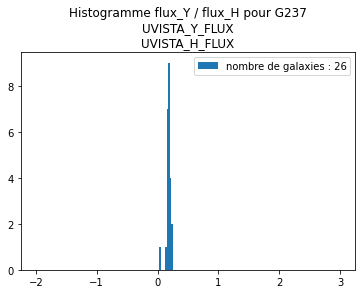

26 c'est mieux, c'est plus cohérent
z max =  8.97858 
z min =  1.4530464
    z    
---------
1.4530464
1.5041462
1.7066717
1.7726275
 1.791442
1.8058997
1.8257284
1.8560712
1.8819436
1.8840451
      ...
 2.019678
2.0417497
 2.043562
 2.072946
2.4112594
2.5217526
2.6834345
2.8849618
  8.97858
       --
       --
Length = 26 rows
z_min =  1.4530464 z_max =  2.8849618


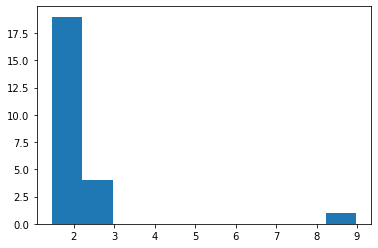

In [18]:
# histogramme de G237
# Attention, pour l'intention aucune figure n'est sauvegardée

Y_H_G237 = matched_cat["UVISTA_Y_FLUX"] / matched_cat["UVISTA_H_FLUX"]

print(Y_H_G237)

plt.hist(Y_H_G237 , bins=200 , range=(-2,3) , label="nombre de galaxies : {}".format(len(Y_H_G237)))
plt.legend()
plt.title("Histogramme flux_Y / flux_H pour G237\nUVISTA_Y_FLUX\nUVISTA_H_FLUX")
#plt.savefig("hist_flux_Y_H_G237.pdf")
plt.show()

print(len(Y_H_G237) , "c'est mieux, c'est plus cohérent")

print('z max = ',np.max(matched_cat["z"]),'\nz min = ',np.min(matched_cat["z"]))
z_tri = np.sort(matched_cat["z"] , kind='quicksort')
print(z_tri)
z_min , z_max = z_tri[0] , z_tri[-4]
print('z_min = ',z_min,'z_max = ',z_max)

#Juste pour voir si les z photo ne sont pas complétement absurdes
plt.hist(matched_cat["z"])
plt.show()

# je normalise
# ...

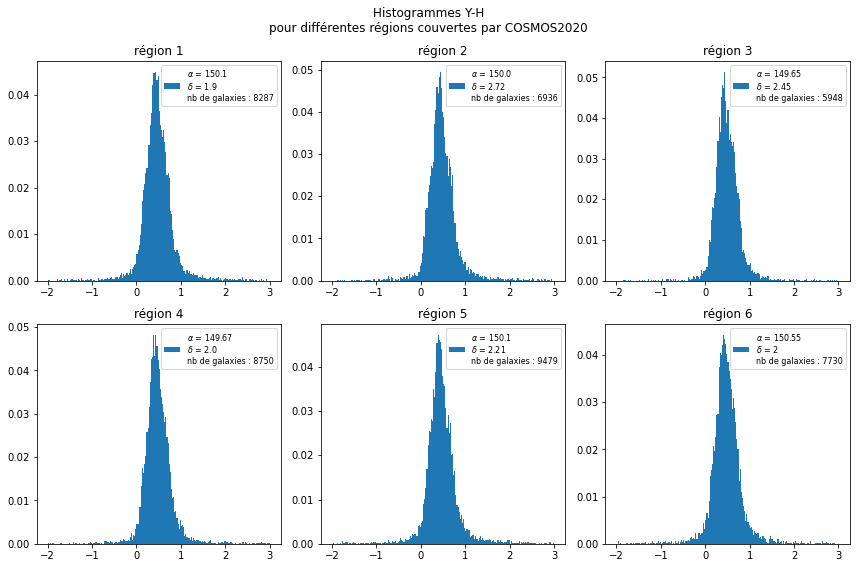

KS test entre G237 et région 1 : D = 0.8146984165357186   p-value = 0.0
KS test entre G237 et région 2 : D = 0.8108423200233168   p-value = 1.1909221856409083e-17
KS test entre G237 et région 3 : D = 0.8554562320796087   p-value = 1.4625486020388847e-20
KS test entre G237 et région 4 : D = 0.8384219554030875   p-value = 9.992007221626409e-16
KS test entre G237 et région 5 : D = 0.7986463620981388   p-value = 3.3306690738754696e-16
KS test entre G237 et région 6 : D = 0.820112022925622   p-value = 3.3292494561771413e-18


KS test entre la région 1 et la région 2 : D = 0.02423720866441148   p-value = 0.023871170569821132
KS test entre la région 1 et la région 3 : D = 0.04433917722176665   p-value = 2.4285672177715156e-06
KS test entre la région 1 et la région 4 : D = 0.027285478251909173   p-value = 0.003474485823992013
KS test entre la région 1 et la région 5 : D = 0.03264440385957786   p-value = 0.00015982600838915229
KS test entre la région 1 et la région 6 : D = 0.015337270836558127 

In [19]:
# histogramme des autres zones

### !!! la zone 6 n'était pas très bonne ###

from scipy.stats import ks_2samp

# initialisation de la liste des Y_H et tableau des ks test
Y_Hs = []
KS = []

# Définition des points
points = [
    (150.1, 1.9),
    (150.0, 2.72),
    (149.65, 2.45),
    (149.67, 2.0),
    (150.1, 2.21),
    (150.55, 2)
]

up_alpha = (12 + 1) / 60
up_delta = (5.5 + 1) / 60

# Création de la grille de sous-graphiques
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (x, y) in enumerate(points, 1):
    # Calcul des bornes des masques
    alpha_min = x - up_alpha
    alpha_max = x + up_alpha
    delta_min = y - up_delta
    delta_max = y + up_delta

    # Création du masque
    mask = (cat["alpha"] >= alpha_min) & (cat["alpha"] <= alpha_max) & \
           (cat["delta"] >= delta_min) & (cat["delta"] <= delta_max) & \
           (cat["z"] >= z_min) & (cat["z"] <= z_max)

    # Calcul des rapports Y_H
    Y_H = cat["UVISTA_Y_FLUX"][mask] / cat["UVISTA_H_FLUX"][mask]
    #stockage dans une liste
    Y_Hs.append(Y_H)
    KS.append(ks_2samp(Y_H_G237,Y_H))

    # Tracé de l'histogramme correspondant (wouha stylé je n'y aurais jamais pensé)
    row = (i - 1) // 3
    col = (i - 1) % 3

    #Pour la version non normalisée, la version précédente fonctionne bien
    hist, bins, _ = axs[row, col].hist(Y_H, bins=200, range=(-2, 3))
    axs[row, col].set_title("région {}".format(i))
    axs[row, col].legend(["$\\alpha$ = {}\n$\\delta$ = {}\nnb de galaxies : {}".format(x, y , len(Y_H))] , fontsize=8)

    hist = hist / sum(hist) #renormalisation

    axs[row, col].cla()  # Efface l'histogramme précédent
    axs[row, col].bar(bins[:-1], hist, width=(bins[1] - bins[0]), align='edge')
    axs[row, col].set_title("région {}".format(i))
    axs[row, col].legend(["$\\alpha$ = {}\n$\\delta$ = {}\nnb de galaxies : {}".format(x, y , len(Y_H))] , fontsize=8)

# Titre global
plt.suptitle("Histogrammes Y-H\npour différentes régions couvertes par COSMOS2020")

# Ajustement des espacements entre les sous-graphiques
plt.tight_layout()

#plt.savefig("hist_flux_Y_H_regions.pdf")
plt.show()

for i in range(len(KS)):
    print("KS test entre G237 et région {} : D = {}   p-value = {}".format(i+1,KS[i][0],KS[i][1]))

print('\n')

for i in range(len(Y_Hs)):
    for j in range(len(Y_Hs)):
        if j > i:
            blou = ks_2samp(Y_Hs[i],Y_Hs[j])
            print("KS test entre la région {} et la région {} : D = {}   p-value = {}".format(i+1,j+1,blou[0],blou[1]))



# Diagrammes de couleur

In [20]:
matched_cat[[1]]

ID,alpha,delta,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,photoz,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,

/Users/Gabriel/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


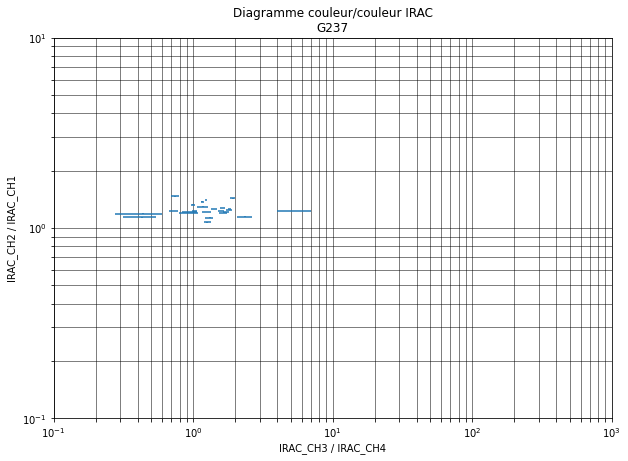

In [25]:

y = matched_cat["IRAC_CH2_FLUX"] / matched_cat["IRAC_CH1_FLUX"]
x = matched_cat["IRAC_CH3_FLUX"] / matched_cat["IRAC_CH4_FLUX"]

err_y = np.abs(y)*np.sqrt( (matched_cat["IRAC_CH2_FLUXERR"]/matched_cat["IRAC_CH2_FLUX"])**2
                          + (matched_cat["IRAC_CH2_FLUXERR"]/matched_cat["IRAC_CH2_FLUX"])**2 )
err_x = np.abs(x)*np.sqrt( (matched_cat["IRAC_CH3_FLUXERR"]/matched_cat["IRAC_CH3_FLUX"])**2
                          + (matched_cat["IRAC_CH4_FLUXERR"]/matched_cat["IRAC_CH4_FLUX"])**2 )

fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
plt.errorbar( x , y , xerr=err_x, yerr=err_y , linestyle='None')
plt.xlabel("IRAC_CH3 / IRAC_CH4")
plt.ylabel("IRAC_CH2 / IRAC_CH1")
plt.xscale('log')
plt.yscale('log')
plt.yticks([0.1,1,10])
plt.xticks([0.1,1,10,100,1000])
plt.title("Diagramme couleur/couleur IRAC\nG237")

# Définition des intervalles personnalisés pour la grille
x_major_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_major_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.xaxis.set_major_locator(ticker.FixedLocator(x_major_ticks))
ax.yaxis.set_major_locator(ticker.FixedLocator(y_major_ticks))

# Activation de la grille uniquement pour les intervalles principaux
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')

plt.savefig("G237_diagramme_couleur_IRAC.pdf")
plt.show()